In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
import datetime

In [2]:
## data location
data_dir = u'C:\\Users\\siltan\\Documents\\kaggle\\elo merchant\\data\\all\\'
output_dir = u'C:\\Users\\siltan\\Documents\\kaggle\\elo merchant\\output\\'

In [3]:
train_df = pd.read_csv(data_dir+"\\train.csv", parse_dates=["first_active_month"])
test_df = pd.read_csv(data_dir+"test.csv", parse_dates=["first_active_month"])
#print("Number of rows and columns in train set : ",train_df.shape)
#print("Number of rows and columns in test set : ",test_df.shape)

In [4]:
train_base = pd.DataFrame(train_df['card_id'])
test_base = pd.DataFrame(test_df['card_id'])

# Target Column Exploration

In [5]:
#target_col = 'target'
#plt.figure(figsize=(8,6))
#plt.scatter(range(len(train_df)),np.sort(train_df[target_col].values))
#plt.xlabel('index',fontsize = 12)
#plt.ylabel('loyalty score',fontsize = 12)
#plt.show()

In [6]:
#plt.figure(figsize=(12,8))
#sns.distplot(train_df[target_col].values,bins = 50, kde = False, color = 'darkblue' )
#plt.xlabel('loyalty score bin',fontsize = 12)
#plt.title('loyalty score distribution',fontsize = 12)
#plt.show()

# historical purchase data

In [7]:
#print '# of target <-30:' , (train_df[target_col]<-30).sum()
#print '% of target <-30:' , (train_df[target_col]<-30).sum()/float(len(train_df))

In [5]:
hist_df = pd.read_csv(data_dir+"\\historical_transactions.csv")
#hist_df.head()
#hist_df.shape
new_m_txn_df = pd.read_csv(data_dir+"\\new_merchant_transactions.csv")
#new_m_txn_df.head()

In [6]:
merch_df = pd.read_csv(data_dir+"\\merchants.csv")
# remove duplicates records of merchants
merch_df = merch_df.drop_duplicates(subset='merchant_id', keep='last', inplace=False)

In [14]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Variable 5.1 - txn data

In [8]:
hist_df.columns

Index([u'authorized_flag', u'card_id', u'city_id', u'category_1',
       u'installments', u'category_3', u'merchant_category_id', u'merchant_id',
       u'month_lag', u'purchase_amount', u'purchase_date', u'category_2',
       u'state_id', u'subsector_id'],
      dtype='object')

In [9]:
for df in [hist_df,new_m_txn_df]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [10]:
 for df in [hist_df,new_m_txn_df]:
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 

In [11]:
for df in [hist_df,new_m_txn_df]:
    reduce_mem_usage(df, verbose=True)

Mem. usage decreased to 1582.00 Mb (65.0% reduction)
Mem. usage decreased to 102.00 Mb (66.0% reduction)


In [ ]:
# missing value check and imputation
print len(hist_df)
print hist_df.groupby('merchant_id')['card_id'].size().reset_index()['card_id'].sum()
hist_df.groupby('merchant_id')['card_id'].size()

In [12]:
for df in [hist_df,new_m_txn_df]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_UNKNOWN',inplace=True)

In [13]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id',
            'city_id','state_id','category_2','category_3']:
    aggs[col] = ['nunique']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var','nunique']
aggs['purchase_date'] = ['max','min','nunique']
aggs['month_lag'] = ['max','min','mean','var','nunique']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean','nunique']
aggs['weekend'] = ['sum', 'mean','nunique']
aggs['category_1'] = ['sum', 'mean','nunique']
aggs['card_id'] = ['size']


In [15]:
new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = hist_df.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)

In [16]:
new_columns = get_new_columns('new',aggs)
df_new_trans_group = new_m_txn_df.groupby('card_id').agg(aggs)
df_new_trans_group.columns = new_columns
df_new_trans_group.reset_index(drop=False,inplace=True)

In [17]:
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_daily_txn_cnt'] = df_hist_trans_group['hist_card_id_size']/df_hist_trans_group['hist_purchase_date_nunique']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days

df_new_trans_group['new_purchase_date_diff'] = (df_new_trans_group['new_purchase_date_max'] - df_new_trans_group['new_purchase_date_min']).dt.days
df_new_trans_group['new_purchase_date_average'] = df_new_trans_group['new_purchase_date_diff']/df_new_trans_group['new_card_id_size']
df_new_trans_group['new_purchase_daily_txn_cnt'] = df_new_trans_group['new_card_id_size']/df_new_trans_group['new_purchase_date_nunique']
df_new_trans_group['new_purchase_date_uptonow'] = (datetime.datetime.today() - df_new_trans_group['new_purchase_date_max']).dt.days

In [82]:
#hist_df.groupby(['category_2'])['purchase_amount'].transform('mean')
#for df in [hist_df,new_m_txn_df]:
#    for col in ['category_1','category_2','category_3','city_id','state_id','merchant_category_id']:
#        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
#        df[col+'_mean_diff'] = df['purchase_amount'] - df[col+'_mean']
#        aggs[col+'_mean'] = ['mean'] 
#        aggs[col+'_mean_diff'] = ['min', 'max','sum','mean'] 

In [18]:
df_hist_trans_group['hist_purchase_monthly_txn_amt'] = df_hist_trans_group['hist_purchase_amount_sum']/df_hist_trans_group['hist_month_lag_nunique']
df_hist_trans_group['hist_purchase_monthly_txn_cnt'] = df_hist_trans_group['hist_card_id_size']/df_hist_trans_group['hist_month_lag_nunique']
df_new_trans_group['new_purchase_monthly_txn_amt'] = df_new_trans_group['new_purchase_amount_sum']/df_new_trans_group['new_month_lag_nunique']
df_new_trans_group['new_purchase_monthly_txn_cnt'] = df_new_trans_group['new_card_id_size']/df_new_trans_group['new_month_lag_nunique']

# Variable 5.2 - Tenure

In [19]:
train_df2 = train_df[['card_id','first_active_month']]
test_df2 = test_df[['card_id','first_active_month']]
train_df2['tenure_mth'] = train_df2['first_active_month'].apply(lambda x: pd.Timestamp('20190101').to_period('M') - x.to_period('M')if not pd.isnull(x) else np.NaN)
test_df2['tenure_mth'] = test_df2['first_active_month'].apply(lambda x: pd.Timestamp('20190101').to_period('M') - x.to_period('M') if not pd.isnull(x) else np.NaN)

In [20]:
train_df2["year"] = train_df2["first_active_month"].dt.year
test_df2["year"] = test_df2["first_active_month"].dt.year
train_df2["month"] = train_df2["first_active_month"].dt.month
test_df2["month"] = test_df2["first_active_month"].dt.month

# Variable 5.3 - Volume/Trip per Dimension

In [21]:
def vol_trip_per_dimension(df,dimension,tag):
    gdf = df.groupby(['card_id',dimension]).agg({'purchase_amount': ['sum','size']}).reset_index()
    gdf.columns = ['card_id',dimension,'amt','trip']       
    aggs = {}
    for col in ['amt','trip']:
        aggs[col] = ['mean','max','min','var']
    
    new_columns = get_new_columns(tag+'_by_'+dimension,aggs)
    gdf_d = gdf.groupby('card_id').agg(aggs)
    gdf_d.columns = new_columns
    return gdf_d

In [22]:
train_df3 = train_base
test_df3 = test_base
for i in ['city_id','state_id','merchant_category_id','merchant_id',
          'category_1','category_2','category_3','installments','subsector_id',
          'month_lag','weekofyear','month','dayofweek','weekend']:
    gdf = vol_trip_per_dimension(hist_df,i,'h')
    train_df3 = pd.merge(train_df3, gdf, on="card_id", how="left")
    test_df3 = pd.merge(test_df3, gdf, on="card_id", how="left")
    gdf = vol_trip_per_dimension(new_m_txn_df,i,'n')
    train_df3 = pd.merge(train_df3, gdf, on="card_id", how="left")
    test_df3 = pd.merge(test_df3, gdf, on="card_id", how="left")

# Variable 5.4 - clumpness

In [23]:
def max_days_between_two_purchase(df,tag):
    tmp = df[['card_id','purchase_date']]
    tmp['sort_num'] = tmp.groupby('card_id').purchase_date.rank(ascending=1,method='dense')
    tmp['sort_num2'] = tmp['sort_num']-1
    tmp = tmp.merge(tmp, left_on = ['card_id','sort_num'], right_on = ['card_id','sort_num2'], how = 'left')
    tmp['purchase_date_delta'] = (tmp['purchase_date_y'] - tmp['purchase_date_x']).dt.days
    output = pd.DataFrame(tmp.groupby('card_id')['purchase_date_delta'].max()).reset_index()
    output.columns = ['card_id','max_day_bt_purchase_'+tag]
    return output

In [24]:
train_df4 = train_base
test_df4 = test_base

gdf = max_days_between_two_purchase(hist_df,'')
train_df4 = pd.merge(train_df4, gdf, on="card_id", how="left")
test_df4 = pd.merge(test_df4, gdf, on="card_id", how="left")

gdf = max_days_between_two_purchase(new_m_txn_df,'n')
train_df4 = pd.merge(train_df4, gdf, on="card_id", how="left")
test_df4 = pd.merge(test_df4, gdf, on="card_id", how="left")

# Variable 5.5 - ranking

In [25]:
def ranking1(df,var):
    gdf = df[['card_id'] + [var]]
    gdf[var + 'sort_num']=gdf[var].rank(ascending=1,method='min')
    gdf[var + '_bin'] = ((gdf[var +'sort_num'] / (len(gdf)+1) *100)+1).astype(int)
    #gdf.groupby('hist_amt_rank_bin').agg({'sort_num':['max','min','size'],'hist_purchase_amount_sum':['max','min','size']})
    #output = gdf[['card_id',var + '_bin',var + 'sort_num']] 
    output = gdf[['card_id',var + '_bin']] 
    return output

In [26]:
train_df5 = train_base
test_df5 = test_base

gdf = ranking1(df_hist_trans_group,'hist_purchase_amount_sum')

train_df5 = pd.merge(train_df5, gdf, on="card_id", how="left")
test_df5 = pd.merge(test_df5, gdf, on="card_id", how="left")

gdf = ranking1(df_hist_trans_group,'hist_card_id_size')

train_df5 = pd.merge(train_df5, gdf, on="card_id", how="left")
test_df5 = pd.merge(test_df5, gdf, on="card_id", how="left")


gdf = ranking1(df_new_trans_group,'new_purchase_amount_sum')

train_df5 = pd.merge(train_df5, gdf, on="card_id", how="left")
test_df5 = pd.merge(test_df5, gdf, on="card_id", how="left")

gdf = ranking1(df_new_trans_group,'new_card_id_size')

train_df5 = pd.merge(train_df5, gdf, on="card_id", how="left")
test_df5 = pd.merge(test_df5, gdf, on="card_id", how="left")

train_df5 = train_df5.fillna(0)
test_df5 = test_df5.fillna(0)

In [27]:
var = 'authorized_flag'
gdf = new_m_txn_df[['card_id', 'purchase_amount'] + [var]]
gdf = gdf.groupby(['card_id']+ [var]).agg({'purchase_amount': ['sum','size']}).reset_index()

In [29]:
gdf.columns = ['card_id',var,'amt','trip']
gdf.head()

,card_id,authorized_flag,amt,trip
0,C_ID_00007093c1,1,-1.328125,2
1,C_ID_0001238066,1,-14.851562,26
2,C_ID_0001506ef0,1,-1.447266,2
3,C_ID_0001793786,1,-0.229004,31
4,C_ID_000183fdda,1,-6.589844,11


# Variable 5.6 - ranking by city/state

In [ ]:
def ranking2(df,var):
    gdf = df[['card_id'] + [var]]
    gdf[var + 'sort_num']=gdf[var].rank(ascending=1,method='min')
    gdf[var + '_bin'] = ((gdf[var +'sort_num'] / (len(gdf)+1) *100)+1).astype(int)
    #gdf.groupby('hist_amt_rank_bin').agg({'sort_num':['max','min','size'],'hist_purchase_amount_sum':['max','min','size']})
    #output = gdf[['card_id',var + '_bin',var + 'sort_num']] 
    output = gdf[['card_id',var + '_bin']] 
    return output
for df in [hist_df,new_m_txn_df]:


In [521]:
#for df in [hist_df,new_m_txn_df]:
var = 'category_1'
df = new_m_txn_df
tag = 'n'




gdf = df[['card_id',var,'purchase_amount']]
gdf = gdf.groupby(['card_id',var]).agg({'purchase_amount':['max','sum','mean','size']}).reset_index()
agg_col = [tag+'_'+var+'_max_amt',tag+'_'+var+'_sum_amt',tag+'_'+var+'_mean_amt',tag+'_'+var+'_trip']
gdf.columns = ['card_id',var] + agg_col

gdf2 = gdf.groupby(var)[tag+'_'+var+'_sum_amt'].sum()

In [528]:
gdf2.index[0]

0

In [490]:
print gdf.columns
gdf['category_1'].drop_duplicates()

Index([u'card_id', u'category_1', u'n_category_1_max_amt',
       u'n_category_1_sum_amt', u'n_category_1_mean_amt',
       u'n_category_1_trip'],
      dtype='object')


0    0
2    1
Name: category_1, dtype: int64

In [493]:
list(gdf[var].drop_duplicates())

[0L, 1L]

# Agg

In [474]:
#del hist_df;gc.collect()
#del new_m_txn_df;gc.collect()


train_agg = train_base.merge(df_hist_trans_group,on='card_id',how='left')
test_agg = test_base.merge(df_hist_trans_group,on='card_id',how='left')

train_agg = train_agg.merge(df_new_trans_group,on='card_id',how='left')
test_agg = test_agg.merge(df_new_trans_group,on='card_id',how='left')

#del df_hist_trans_group;gc.collect()
#del df_new_trans_group;gc.collect()

train_agg = train_agg.merge(train_df2,on='card_id',how='left')
test_agg = test_agg.merge(test_df2,on='card_id',how='left')

#del train_df2;gc.collect()
#del test_df2;gc.collect()

train_agg = train_agg.merge(train_df3,on='card_id',how='left')
test_agg = test_agg.merge(test_df3,on='card_id',how='left')

#del train_df3;gc.collect()
#del test_df3;gc.collect()

train_agg = train_agg.merge(train_df4,on='card_id',how='left')
test_agg = test_agg.merge(test_df4,on='card_id',how='left')

#del train_df4;gc.collect()
#del test_df4;gc.collect()

train_agg = train_agg.merge(train_df5,on='card_id',how='left')
test_agg = test_agg.merge(test_df5,on='card_id',how='left')

#del train_df5;gc.collect()
#del test_df5;gc.collect()

In [475]:
for df in [train_agg,test_agg]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_purchase_date_max',\
                     'new_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    
    df['purchase_monthly_amount_diff'] = df['new_purchase_monthly_txn_amt']-df['hist_purchase_monthly_txn_amt']
    df['purchase_monthly_amount_diff_ratio'] = (df['purchase_monthly_amount_diff'])/df['hist_purchase_monthly_txn_amt']
 
    df['purchase_monthly_trip_diff'] = df['new_purchase_monthly_txn_cnt']-df['hist_purchase_monthly_txn_cnt']
    df['purchase_monthly_trip_diff_ratio'] = (df['purchase_monthly_trip_diff'])/df['hist_purchase_monthly_txn_cnt']

    df['purchase_amount_mean_diff'] = df['new_purchase_amount_mean']-df['hist_purchase_amount_mean']
    df['purchase_amount_mean_diff_ratio'] = (df['purchase_amount_mean_diff'])/df['hist_purchase_amount_mean']

In [476]:
train_df = train_df[['target','card_id','feature_1','feature_2','feature_3']].merge(train_agg,on='card_id',how='left')
test_df = test_df[['card_id','feature_1','feature_2','feature_3']].merge(test_agg,on='card_id',how='left')

In [477]:
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)
train_df = train_df.drop(columns='outliers', inplace=False)

# Training

In [478]:
#c = list(train_df.columns)
cols_to_use = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target_col = 'target'

In [479]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        # 1
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.02,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.9,
        "bagging_frequency" : 5,
        "bagging_seed" : 11,
        "verbosity" : -1,
        "lambda_l1": 0.1
      
        
        # 2
        #"objective" : "regression",
        #"metric" : "rmse",
        #"num_leaves" : 35,
        #"min_child_weight" : 75,
        #"learning_rate" : 0.02,
        #"bagging_fraction" : 0.7,
        #"feature_fraction" : 0.5,
        #"bagging_frequency" : 5,
        #"bagging_seed" : 2016,
        #"verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [480]:
train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.70264
[200]	valid_0's rmse: 3.69005
[300]	valid_0's rmse: 3.68703
[400]	valid_0's rmse: 3.6855
[500]	valid_0's rmse: 3.68431
[600]	valid_0's rmse: 3.68425
Early stopping, best iteration is:
[577]	valid_0's rmse: 3.6839
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.64679
[200]	valid_0's rmse: 3.63495
[300]	valid_0's rmse: 3.63112
[400]	valid_0's rmse: 3.63006
Early stopping, best iteration is:
[398]	valid_0's rmse: 3.62996
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.67468
[200]	valid_0's rmse: 3.65555
[300]	valid_0's rmse: 3.64677
[400]	valid_0's rmse: 3.64497
[500]	valid_0's rmse: 3.6423
[600]	valid_0's rmse: 3.64131
[700]	valid_0's rmse: 3.64079
[800]	valid_0's rmse: 3.63977
[900]	valid_0's rmse: 3.64017
Early stopping, best iteration is:
[819]	valid_0's rmse: 3.63958
Training until validation scores don't improve fo

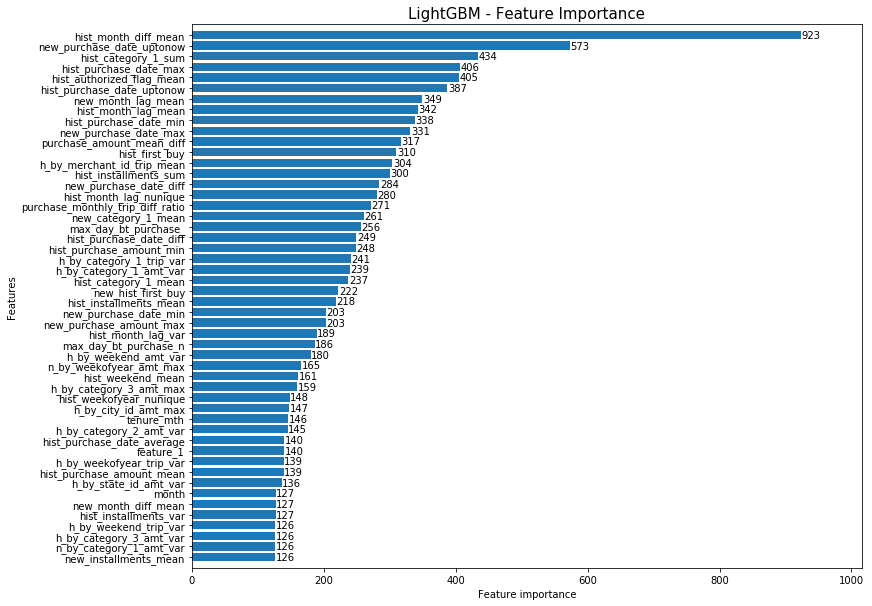

In [481]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [127]:
#len(model.feature_importance())
#len(cols_to_use)
#fi = pd.DataFrame(model.feature_importance(),index=cols_to_use, columns=['fea_importance'])
#cols_to_use2 = list(fi.sort_values('fea_importance',ascending = False).head(100).index)

In [482]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv(output_dir + "lgb_var5_3.csv", index=False)

In [483]:
len(sub_df)

123623

remove outliner

In [535]:
df_train_wo_ol = train_df[train_df['target'] >=-30]

In [540]:
train_X = df_train_wo_ol[cols_to_use]
train_y = df_train_wo_ol[target_col].values

pred_test_wo_ol = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(df_train_wo_ol):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_wo_ol += pred_test_tmp
pred_test_wo_ol /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.71844
Early stopping, best iteration is:
[12]	valid_0's rmse: 1.71822
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.71726
Early stopping, best iteration is:
[3]	valid_0's rmse: 1.71693
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70827
Early stopping, best iteration is:
[2]	valid_0's rmse: 1.70796
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.73196
Early stopping, best iteration is:
[2]	valid_0's rmse: 1.73161
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.7143
Early stopping, best iteration is:
[4]	valid_0's rmse: 1.71408


In [579]:
model_without_outliers = pd.DataFrame({"card_id":test_df["card_id"].values})
model_without_outliers["target"] = pred_test_wo_ol

In [545]:
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1

cols_to_use2 = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers','outliers']]
target_col2 = 'outliers'

In [547]:
train_X = train_df[cols_to_use2]
test_X = test_df[cols_to_use2]
train_y = train_df[target_col2].values

pred_test_ol = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_ol += pred_test_tmp
pred_test_ol /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.100915
[200]	valid_0's rmse: 0.100755
[300]	valid_0's rmse: 0.100792
Early stopping, best iteration is:
[256]	valid_0's rmse: 0.10074
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.0985397
[200]	valid_0's rmse: 0.098441
Early stopping, best iteration is:
[188]	valid_0's rmse: 0.0984207
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.0996748
[200]	valid_0's rmse: 0.0992748
[300]	valid_0's rmse: 0.099168
Early stopping, best iteration is:
[282]	valid_0's rmse: 0.0991648
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.099209
[200]	valid_0's rmse: 0.0988466
[300]	valid_0's rmse: 0.0987241
[400]	valid_0's rmse: 0.0987114
Early stopping, best iteration is:
[395]	valid_0's rmse: 0.0987089
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.101487
[200]	vali

In [550]:
df_outlier_prob = pd.DataFrame({"card_id":test_df["card_id"].values})
df_outlier_prob["target"] = pred_test_ol

In [552]:
# In case missing some predictable outlier, we choose top 25000 with highest outliers likelyhood.
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target',ascending = False).head(25000)['card_id'])

In [582]:
most_likely_liers = sub_df.merge(outlier_id,how='right')
most_likely_liers.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.874758
1,C_ID_f7cada36d3,0.479522
2,C_ID_6d8dba8475,-0.826553
3,C_ID_7f1041e8e1,-5.216784
4,C_ID_22e4a47c72,-0.277082


In [583]:
target1 = test_base.merge(most_likely_liers,how='left')

In [580]:
target2 = model_without_outliers

In [585]:
combiner = lambda x, y: np.where(pd.isna(x), y, x)

In [587]:
target1.combine(target2, combiner).to_csv("lgb_var5_4_ol.csv", index=False)

# Variable 1 - Volume

In [11]:
def change_agg_col(df,tag):
    col = []
    for i in list(df.columns):
        col += [i[0]+'-'+i[1]+'-'+tag]
    return col

In [12]:
## volume of historical txn
gdf = hist_df.groupby('card_id').agg({'purchase_amount': ['min', 'max','sum','mean', 'std','size'], 'month_lag': ['min','max']})
gdf.columns = change_agg_col(gdf,'h')
train_df2 = pd.merge(train_df, gdf, on="card_id", how="left")
test_df2 = pd.merge(test_df, gdf, on="card_id", how="left")

## volume of new merchant txn
gdf = new_m_txn_df.groupby('card_id').agg({'purchase_amount': ['min', 'max','sum','mean', 'std','size'], 'month_lag': ['min','max']})
gdf.columns = change_agg_col(gdf,'n')
train_df2 = pd.merge(train_df2, gdf, on="card_id", how="left")
test_df2 = pd.merge(test_df2, gdf, on="card_id", how="left")

# Variable 3 - Dimension Count

In [15]:
## distinct state, city, merchant, etc.
def change_agg_col2(df,tag):
    col = []
    for i in list(df.columns):
        col += [i+'-cnt-'+tag]
    return col

In [17]:
gdf = hist_df.groupby('card_id').agg({'city_id': pd.Series.nunique, 
                            'state_id': pd.Series.nunique,
                            'merchant_category_id':pd.Series.nunique,
                            'merchant_id':pd.Series.nunique,
                            'category_1':pd.Series.nunique,
                            'category_2':pd.Series.nunique,
                            'category_3':pd.Series.nunique,
                            'installments':pd.Series.nunique,
                            'subsector_id':pd.Series.nunique,
                            'month_lag':pd.Series.nunique})

gdf.columns = change_agg_col2(gdf,'h')
train_df2 = pd.merge(train_df2, gdf, on="card_id", how="left")
test_df2 = pd.merge(test_df2, gdf, on="card_id", how="left")

## volume of new merchant txn
gdf = new_m_txn_df.groupby('card_id').agg({'city_id': pd.Series.nunique, 
                            'state_id': pd.Series.nunique,
                            'merchant_category_id':pd.Series.nunique,
                            'merchant_id':pd.Series.nunique,
                            'category_1':pd.Series.nunique,
                            'category_2':pd.Series.nunique,
                            'category_3':pd.Series.nunique,
                            'installments':pd.Series.nunique,
                            'subsector_id':pd.Series.nunique,
                            'month_lag':pd.Series.nunique})
gdf.columns = change_agg_col2(gdf,'n')
train_df2 = pd.merge(train_df2, gdf, on="card_id", how="left")
test_df2 = pd.merge(test_df2, gdf, on="card_id", how="left")

# Variable 4.2 - Volume/Trip per weekday/weekend

In [184]:
hist_df['weekday'] = pd.to_datetime(hist_df['purchase_date']).apply(lambda x: x.weekday())
hist_df['workday'] = hist_df['weekday'].apply(lambda x: 1 if x<5 else 0 )

In [185]:
new_m_txn_df['weekday'] = pd.to_datetime(new_m_txn_df['purchase_date']).apply(lambda x: x.weekday())
new_m_txn_df['workday'] = new_m_txn_df['weekday'].apply(lambda x: 1 if x<5 else 0 )

In [186]:
for i in ['weekday','workday']:
    gdf = vol_trip_per_dimension(hist_df,i,'h')
    train_df2 = pd.merge(train_df2, gdf, on="card_id", how="left")
    test_df2 = pd.merge(test_df2, gdf, on="card_id", how="left")
    gdf = vol_trip_per_dimension(new_m_txn_df,i,'n')
    train_df2 = pd.merge(train_df2, gdf, on="card_id", how="left")
    test_df2 = pd.merge(test_df2, gdf, on="card_id", how="left")

In [195]:
#i = 'workday'
#hist_df.groupby(i).agg({'purchase_amount': ['mean','max','min','std','size']})

# Variable 4.3 - Volume/Trip per merchant tag

In [359]:
# remove duplicates records of merchants
merch_df = merch_df.drop_duplicates(subset='merchant_id', keep='last', inplace=False)

In [361]:
merch_pct = merch_df
for i in ['city_id','state_id','category_1','merchant_group_id','merchant_category_id','subsector_id']:
    merch_tmp = merch_df.groupby(i).agg({'merchant_id':['size']}).reset_index()
    merch_tmp.columns = [i,'mer_cnt_'+i]
    for j in ['avg_sales_lag3','avg_purchases_lag3','avg_sales_lag6','avg_purchases_lag6','avg_sales_lag12','avg_purchases_lag12']:
        merch_tmp2 = pd.merge(merch_df[['merchant_id',i,j]], merch_tmp, on=i, how="left")
        merch_tmp2['sort_num']=merch_tmp2.groupby(i)[j].rank(ascending=1,method='min',na_option = 'top')
        merch_tmp2['pct_'+i+'_'+j] = ((merch_tmp2['sort_num'] / (merch_tmp2['mer_cnt_'+i]+1) *10)+1).astype(int)
        merch_pct = pd.merge(merch_pct,merch_tmp2[['merchant_id','pct_'+i+'_'+j]], on = 'merchant_id', how = 'left')

In [368]:
merch_tag_col = ['merchant_id','merchant_group_id','most_recent_sales_range', 'most_recent_purchases_range','category_4', 
          'pct_city_id_avg_sales_lag3', 'pct_city_id_avg_purchases_lag3',
           'pct_city_id_avg_sales_lag6', 'pct_city_id_avg_purchases_lag6',
           'pct_city_id_avg_sales_lag12', 'pct_city_id_avg_purchases_lag12',
           'pct_state_id_avg_sales_lag3', 'pct_state_id_avg_purchases_lag3',
           'pct_state_id_avg_sales_lag6', 'pct_state_id_avg_purchases_lag6',
           'pct_state_id_avg_sales_lag12', 'pct_state_id_avg_purchases_lag12',
           'pct_category_1_avg_sales_lag3', 'pct_category_1_avg_purchases_lag3',
           'pct_category_1_avg_sales_lag6', 'pct_category_1_avg_purchases_lag6',
           'pct_category_1_avg_sales_lag12',
           'pct_category_1_avg_purchases_lag12',
           'pct_merchant_group_id_avg_sales_lag3',
           'pct_merchant_group_id_avg_purchases_lag3',
           'pct_merchant_group_id_avg_sales_lag6',
           'pct_merchant_group_id_avg_purchases_lag6',
           'pct_merchant_group_id_avg_sales_lag12',
           'pct_merchant_group_id_avg_purchases_lag12',
           'pct_merchant_category_id_avg_sales_lag3',
           'pct_merchant_category_id_avg_purchases_lag3',
           'pct_merchant_category_id_avg_sales_lag6',
           'pct_merchant_category_id_avg_purchases_lag6',
           'pct_merchant_category_id_avg_sales_lag12',
           'pct_merchant_category_id_avg_purchases_lag12',
           'pct_subsector_id_avg_sales_lag3',
           'pct_subsector_id_avg_purchases_lag3',
           'pct_subsector_id_avg_sales_lag6',
           'pct_subsector_id_avg_purchases_lag6',
           'pct_subsector_id_avg_sales_lag12',
           'pct_subsector_id_avg_purchases_lag12']

In [429]:
def vol_trip_per_dimension2(df,dimension,tag):
    gdf = df.groupby(['card_id',dimension]).agg({'amt': ['sum'],'trip': ['sum']}).reset_index()
    gdf.columns = ['card_id',dimension,'amt','trip']      
    gdf = gdf.groupby('card_id').agg({'amt': ['mean','max','min','std','size'],'trip': ['mean','max','min','std']}).reset_index()
    c = change_agg_col(gdf,dimension+'-'+tag)
    c[0] = 'card_id'
    gdf.columns = c
    return gdf

In [426]:
hist_df_m = hist_df.groupby(['card_id','merchant_id']).agg({'purchase_amount': ['sum','size']}).reset_index()
hist_df_m.columns = ['card_id','merchant_id','amt','trip']

new_m_txn_df_m = new_m_txn_df.groupby(['card_id','merchant_id']).agg({'purchase_amount': ['sum','size']}).reset_index()
new_m_txn_df_m.columns = ['card_id','merchant_id','amt','trip']

In [427]:
hist_df_m = pd.merge(hist_df_m,merch_pct[merch_tag_col],on = 'merchant_id', how = 'left')
new_m_txn_df_m = pd.merge(new_m_txn_df_m,merch_pct[merch_tag_col],on = 'merchant_id', how = 'left')

In [428]:
hist_df_m.head()

,card_id,merchant_id,amt,trip,merchant_group_id,most_recent_sales_range,most_recent_purchases_range,category_4,pct_city_id_avg_sales_lag3,pct_city_id_avg_purchases_lag3,pct_city_id_avg_sales_lag6,pct_city_id_avg_purchases_lag6,pct_city_id_avg_sales_lag12,pct_city_id_avg_purchases_lag12,pct_state_id_avg_sales_lag3,pct_state_id_avg_purchases_lag3,pct_state_id_avg_sales_lag6,pct_state_id_avg_purchases_lag6,pct_state_id_avg_sales_lag12,pct_state_id_avg_purchases_lag12,pct_category_1_avg_sales_lag3,pct_category_1_avg_purchases_lag3,pct_category_1_avg_sales_lag6,pct_category_1_avg_purchases_lag6,pct_category_1_avg_sales_lag12,pct_category_1_avg_purchases_lag12,pct_merchant_group_id_avg_sales_lag3,pct_merchant_group_id_avg_purchases_lag3,pct_merchant_group_id_avg_sales_lag6,pct_merchant_group_id_avg_purchases_lag6,pct_merchant_group_id_avg_sales_lag12,pct_merchant_group_id_avg_purchases_lag12,pct_merchant_category_id_avg_sales_lag3,pct_merchant_category_id_avg_purchases_lag3,pct_merchant_category_id_avg_sales_lag6,pct_merchant_category_id_avg_purchases_lag6,pct_merchant_category_id_avg_sales_lag12,pct_merchant_category_id_avg_purchases_lag12,pct_subsector_id_avg_sales_lag3,pct_subsector_id_avg_purchases_lag3,pct_subsector_id_avg_sales_lag6,pct_subsector_id_avg_purchases_lag6,pct_subsector_id_avg_sales_lag12,pct_subsector_id_avg_purchases_lag12
0,C_ID_00007093c1,M_ID_0379adb435,-2.248327,4,39381,D,E,N,6,8,3,5,2,3,6,8,3,5,2,3,6,8,2,5,1,2,6,6,6,6,6,6,6,8,3,4,2,2,6,8,3,4,2,2
1,C_ID_00007093c1,M_ID_06a8d84366,-0.435198,1,4462,B,B,Y,4,5,5,5,5,5,4,5,5,5,5,5,4,4,4,4,4,4,2,4,3,4,3,4,4,5,4,5,4,5,4,5,4,5,4,5
2,C_ID_00007093c1,M_ID_0dabc5a70c,-1.121909,2,35,B,C,N,7,8,7,7,7,7,7,8,7,8,7,7,7,8,7,7,7,7,6,7,6,6,5,5,6,7,7,7,6,7,6,6,6,6,6,6
3,C_ID_00007093c1,M_ID_109e9d2b1d,-1.275931,2,35,B,B,N,6,7,6,6,5,5,6,7,6,6,5,6,6,7,5,6,5,5,4,5,4,4,3,3,6,7,6,7,5,6,5,7,6,7,5,6
4,C_ID_00007093c1,M_ID_15446e939c,0.324212,4,35,C,C,N,7,8,7,7,6,7,7,8,7,7,6,7,7,8,6,7,6,6,6,7,5,5,4,5,8,9,8,8,7,7,8,8,7,8,6,7


In [450]:
for i in ['merchant_group_id','most_recent_sales_range', 'most_recent_purchases_range','category_4']:
    gdf = vol_trip_per_dimension2(hist_df_m,i,'h')
    train_df2 = pd.merge(train_df2, gdf, on="card_id", how="left")
    test_df2 = pd.merge(test_df2, gdf, on="card_id", how="left")
    gdf = vol_trip_per_dimension2(new_m_txn_df_m,i,'n')
    train_df2 = pd.merge(train_df2, gdf, on="card_id", how="left")
    test_df2 = pd.merge(test_df2, gdf, on="card_id", how="left")